# DTSA5510 Final – Unsupervised Algorithms in Machine Learning Final Project

## Project Topic -- AG News Topic Prediction

Having gone through the week 4 BBC news prediction, I found that news prediction is a very interesting topic that involves highly relavent ML techniques we learned in the class, and NLP that we have not learned in the class. Therefore, I decided to continue on the same topic of new prediction in this final project by using a different dataset, the AG News Classification Dataset dataset (*[Click here to access the AG News Classification Dataset on Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset)*), to practice Unsupervised ML. This dataset contains 120,000 training samples. It's a much larger set of training samples than what we used in the week 4 BBC news practice. The Detailed description of the dataset will be included in the the following EDA section.

I will perform EDA, including data cleaning, feature extraction, and transformation to prepare the data for news topic prediction using four different algorithms, among them the NMF is an unsupervised ML we have learned in the class
* NMF 
* SVM
* Logistic Regression
* Random Forest

Upon the modeling, I will compare the performance of these algorithms by the accuracy scores from the best performing model generated by GridSearch.

## Exploratory Data Analysis

### Data Access

*[Follow the download link to the data package for the AG News Classification Dataset on Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/download?datasetVersionNumber=2)*

There are 2 files in the downloaded zip directory:
* test.csv
* train.csv

Both the files have the target variable "Class Index" labeled. We will be combining them as one and use cross validation when building the models. The data structure, number of observation and the varible types will be examined upon loading them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.corpus
import nltk.stem
import nltk.data

import sklearn.linear_model
import sklearn.model_selection
import sklearn.feature_extraction.text
import sklearn.decomposition
import sklearn.cluster
import sklearn.manifold
import sklearn.svm
import sklearn.ensemble
import sklearn.metrics

import itertools
import contractions
import unicodedata
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train_df = pd.read_csv("AGnews/train.csv")
test_df = pd.read_csv("AGnews/test.csv")

# Use 1/100 smaller dataset to test first
# train_df = pd.read_csv("AGnews/train1.csv")
# test_df = pd.read_csv("AGnews/test1.csv")

In [3]:
# Combine train and test data for training
df = pd.concat([train_df, test_df], ignore_index=True)

### Inspect the number of variables and variable types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  127600 non-null  int64 
 1   Title        127600 non-null  object
 2   Description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


### Data fields description

* Class Index - The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech. We will need to convert it to categorical variable in the next step.
* Title: The news title as string object.
* Description: The content of the news as sting object.


### Variable type correction

The "Class Index" is recognized as int64 type upon read in. We are going to coerce it into categorical varaibles and change the names accordingly to make it more explicit.

In [5]:
df["Topic"] = df["Class Index"].astype("category")
df = df.drop(columns=["Class Index"])

# Coerce "Class Index" to categorical and rename values
class_mapping = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}
df['Topic'] = df['Topic'].map(class_mapping)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Title        127600 non-null  object  
 1   Description  127600 non-null  object  
 2   Topic        127600 non-null  category
dtypes: category(1), object(2)
memory usage: 2.1+ MB


### Check null values

It does not seem like there is any null value in any of the columns.

### Remove duplicated content

Duplicated entries will introduce bias to the model. We are going to check if there is any duplicates in the "Title" or "Description".

In [6]:
# Check for duplicated values in the "Title" column
duplicated_titles = df[df.duplicated(subset=['Title'], keep=False)]
duplicated_titles

,Title,Description,Topic
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
6,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...,Business
10,Oil and Economy Cloud Stocks' Outlook,NEW YORK (Reuters) - Soaring crude prices plu...,Business
40,Letters,Target the abusers of legal weapons We can all...,Business
177,Mission Accomplished!,"\\""BAGHDAD, Iraq (CNN) -- Members of Iraq's in...",Sci/Tech
...,...,...,...
127555,Circuit City Cautious on Outlook,"Circuit City Stores Inc. (CC.N: Quote, Profile...",Business
127588,"Search providers seek video, find challenges",Internet search providers are reacting to user...,Sci/Tech
127592,Historic Turkey-EU deal welcomed,The European Union's decision to hold entry ta...,World
127595,Around the world,Ukrainian presidential candidate Viktor Yushch...,World


There are substantial number of duplicated titles, but the duplicated title do not necessarily mean duplicated content. We would like to keep as much information as possible for the training. It'll be a better option to use the "Description" variable for the modeling. Therefore, let's go with removing duplicates in the "Description" Column.

In [7]:
# Check for duplicated values in the "Description" column
# duplicated_descriptions = df[df.duplicated(subset=['Description'], keep=False)]

duplicated_descriptions = df[df.duplicated(subset=['Description'])]
duplicated_descriptions

,Title,Description,Topic
44,State grant to aid Lynn; Bank gives Salem \$10k,Central Square in Lynn should be looking a bit...,Business
532,Florida Residents Face Hurricane Wreckage,"PUNTA GORDA, Fla. - After getting a first look...",World
582,"Phelps, Rival Thorpe in 200M-Free Semis","ATHENS, Greece - Michael Phelps took care of q...",World
606,Venezuelans Throng to Polls in Chavez Referendum,"CARACAS, Venezuela (Reuters) - Venezuelans cr...",World
607,Schumacher Triumphs as Ferrari Seals Formula O...,BUDAPEST (Reuters) - Michael Schumacher cruis...,Sports
...,...,...,...
127309,Vodafone Drops on Report It Supports Bid for S...,"Shares in Vodafone Group Plc, the world #39;s ...",Business
127380,No. 1 LSU overcomes stubborn host Minnesota,MINNEAPOLIS - Top-ranked teams aren #39;t solo...,Sports
127423,Veterans Pronger and McKenzie don #39;t think ...,NHL veterans Chris Pronger and Jim McKenzie th...,Sports
127548,Bad Day for Drug Companies - and Patients,LONDON (Reuters) - Investors in pharmaceutica...,Business


In [8]:
# Remove duplicated rows based on "Title"
df = df.drop_duplicates(subset=['Description'], keep='first', ignore_index=True)
print("Rows with duplicated description/content removed. New shape of the dataframe:", df.shape)

Rows with duplicated description/content removed. New shape of the dataframe: (126182, 3)


### Distribution of different topics

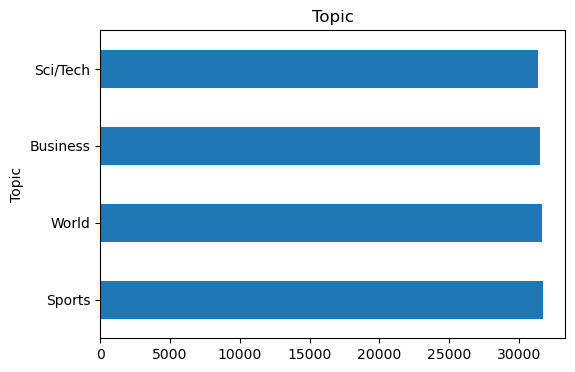

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df.Topic.value_counts().plot.barh(ax=ax, title="Topic");


4 categories of topics distribute almost evenly in the dataset, which is ideal for the modeling purpose.

### Data Cleaning

All text in the "Description" in will be processed with the following steps:
* Converting the text to lowercase format and removing diacritics and contractions.
* Eliminating all non-alphabetic characters, including digits and special symbols.
* Excluding commonly used stop words. (Stop words are frequent words such as "the," "and," "in" that are often disregarded in text analysis to enhance efficiency and emphasize more meaningful words.)
* Applying lemmatization. (Lemmatization is a linguistic process that reduces words to their base or root form, known as a lemma. It involves stripping away inflections and variations, ensuring words like "running" and "ran" are transformed to "run." Lemmatization aids in standardizing language and enhances the accuracy of semantic analysis.)

In [10]:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def text_cleaning(df, column_name):
    df[column_name] = df[column_name].str.lower()
    df[column_name] = df[column_name].str.normalize("NFC")
    df[column_name] = df[column_name].apply(contractions.fix)
    df[column_name] = df[column_name].apply(lambda s: "".join([c if c.isalpha() else " " for c in s]))
    df[column_name] = df[column_name].apply(lambda s: " ".join(["" if w in stop_words else w for w in s.split()]))
    df[column_name] = df[column_name].apply(lambda s: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(s)]))
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Make a copy of the original df
df_original = df.copy()

# Make a reference to df_cleaned
df_cleaned = df

# Clean the Desription column
text_cleaning(df, "Description")

,Title,Description,Topic
0,Wall St. Bears Claw Back Into the Black (Reuters),reuters short seller wall street dwindling ban...,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,reuters private investment firm carlyle group ...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),reuters soaring crude price plus worry economy...,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,reuters authority halted oil export flow main ...,Business
4,"Oil prices soar to all-time record, posing new...",afp tearaway world oil price toppling record s...,Business
...,...,...,...
126177,Around the world,ukrainian presidential candidate viktor yushch...,World
126178,Void is filled with Clement,supply attractive pitching option dwindling da...,Sports
126179,Martinez leaves bitter,like roger clemens almost exactly eight year e...,Sports
126180,5 of arthritis patients in Singapore take Bext...,singapore doctor united state warned painkille...,Business


### Word count distribution

In [12]:
# Function to count words in a text
def count_words(text):
    return len(text.split())

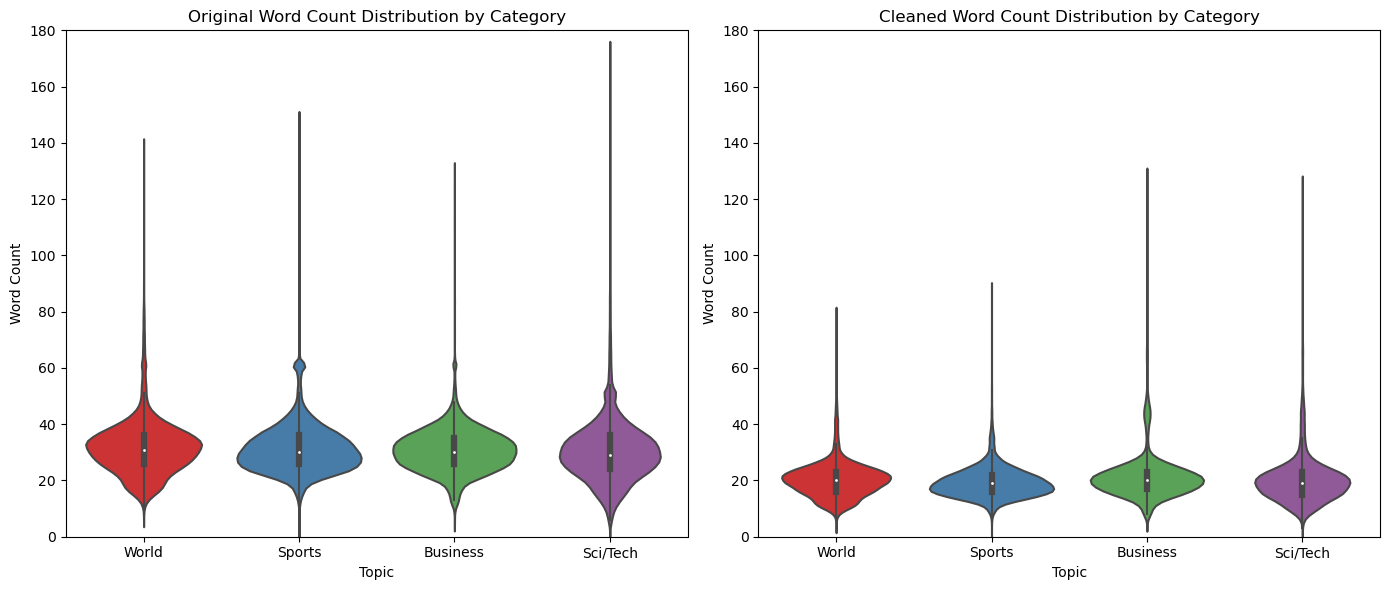

In [13]:
# Apply the word count function to the original and cleaned Description columns
df_original['Original Word Count'] = df_original['Description'].apply(count_words)
df_cleaned['Cleaned Word Count'] = df['Description'].apply(count_words)

# Create a side-by-side violin plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='Topic', y='Original Word Count', data=df_original, palette="Set1")
plt.ylim(0, 180)
plt.title('Original Word Count Distribution by Category')
plt.xlabel('Topic')
plt.ylabel('Word Count')

plt.subplot(1, 2, 2)
sns.violinplot(x='Topic', y='Cleaned Word Count', data=df_cleaned, palette="Set1")
plt.ylim(0, 180)
plt.title('Cleaned Word Count Distribution by Category')
plt.xlabel('Topic')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()


**Comparing the two plots, it's obvious that the length of the description has been overall reduced from above 30 words to about 20. This is a 1/3 reduction in size, which will be helpful in improving the computation efficiency.**

## Feature extraction

Text analysis and natural language processing (NLP) are pivotal in extracting meaningful insights from unstructured textual data. Three widely used techniques in this domain are TF-IDF, Word2Vec, and Latent Dirichlet Allocation (LDA).


**TF-IDF (Term Frequency-Inverse Document Frequency):** TF-IDF is a fundamental technique for converting textual data into numerical vectors while accounting for term importance. It calculates the frequency of each term within a document (TF) and then scales this frequency by the inverse frequency of the term across all documents (IDF). This process highlights terms that are both frequent in a document and unique to it, capturing their significance in conveying meaning. TF-IDF-based vectorization is commonly used for various tasks such as document classification, information retrieval, and text clustering.

**Word2Vec:** Word2Vec is an advanced word embedding technique that leverages neural networks to map words to continuous vector spaces. It captures semantic relationships between words by learning vector representations in such a way that similar words are closer together in the vector space. Word2Vec models, whether Skip-gram or Continuous Bag of Words (CBOW), excel at capturing context and word similarity, making them essential for tasks like sentiment analysis, machine translation, and recommendation systems. These embeddings enable algorithms to grasp the subtle nuances of language semantics.

**Latent Dirichlet Allocation (LDA):** LDA is a probabilistic generative model used for topic modeling, a technique to uncover hidden thematic patterns within a collection of documents. LDA assumes that documents are mixtures of topics, and each topic is characterized by a distribution of words. By analyzing the distribution of words across topics and topics within documents, LDA identifies latent topics that underlie the corpus. This aids in understanding the main themes in a large text dataset, which is valuable for content summarization, trend analysis, and content recommendation.

Together, TF-IDF, Word2Vec, and LDA represent a spectrum of techniques for extracting insights from textual data, each offering unique strengths for different NLP tasks and enabling a deeper understanding of the complex world of language.

**We will expriment with all three of them to see which one separates our data better to decided on which one we should proceed with the modeling.**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

# TF-IDF feature extraction
# Need to set max_feature to ensure the splitted datasets will have same number of features
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True, max_features=2000) 
tfidf_features = tfidf_vectorizer.fit_transform(df['Description'])

# Perform t-SNE on TF-IDF features
tsne_tfidf = TSNE(n_components=2, random_state=42)
tsne_tfidf_results = tsne_tfidf.fit_transform(tfidf_features.toarray())

In [15]:
tfidf_features.shape

(126182, 2000)

In [16]:
# Word2Vec feature extraction
word2vec_model = Word2Vec([text.split() for text in df['Description']], vector_size=100, window=4, min_count=1, sg=1)
word2vec_features = np.array([np.mean([word2vec_model.wv[word] for word in text.split() if word in word2vec_model.wv], axis=0) for text in df['Description']])


# Perform t-SNE on Word2Vec features
tsne_word2vec = TSNE(n_components=2, random_state=42)
tsne_word2vec_results = tsne_word2vec.fit_transform(word2vec_features)

In [17]:
# LDA topic modeling
lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_features = lda_model.fit_transform(tfidf_features)


# Perform t-SNE on LDA features
tsne_lda = TSNE(n_components=2, random_state=42)
tsne_lda_results = tsne_lda.fit_transform(lda_features)

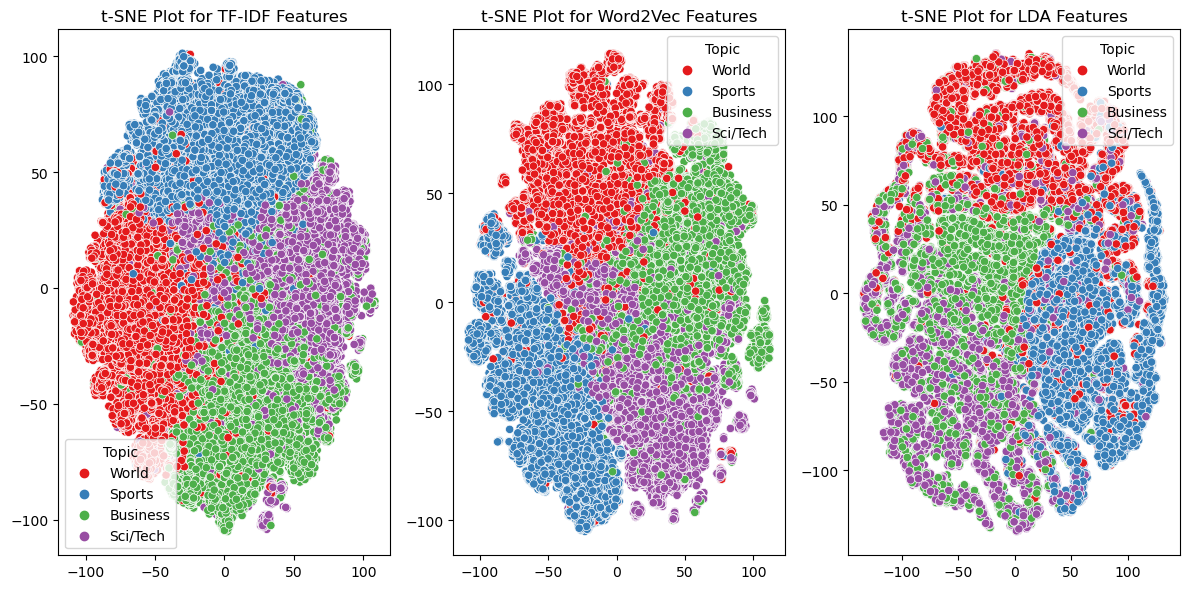

In [18]:
# Plot t-SNE results for TF-IDF features
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x=tsne_tfidf_results[:, 0], y=tsne_tfidf_results[:, 1], hue=df['Topic'], palette="Set1")
plt.title('t-SNE Plot for TF-IDF Features')

# Plot t-SNE results for Word2Vec features
plt.subplot(1, 3, 2)
sns.scatterplot(x=tsne_word2vec_results[:, 0], y=tsne_word2vec_results[:, 1], hue=df['Topic'], palette="Set1")
plt.title('t-SNE Plot for Word2Vec Features')

# Plot t-SNE results for LDA features
plt.subplot(1, 3, 3)
sns.scatterplot(x=tsne_lda_results[:, 0], y=tsne_lda_results[:, 1], hue=df['Topic'], palette="Set1")
plt.title('t-SNE Plot for LDA Features')

plt.tight_layout()
plt.show()

*In the above TSNE plots, we can see that TF-IDF based feature extraction enables eparations between different categories, though it's not perfect. The word2vec and LDA based feature extraction does not really spearate the categories. The reason might be the descriptions are too short to use these sematic models. Therefor, TF-IDF provides a better way of feature extraction in this context.*

### Modeling

LDA does not do well as TF-IDF or word2vec. We will choose TF-IDF for feature extraction method. We will apply both unsupervised and supervised learning algorithms for modelling. Here are the algorithms that I will try:

* Non-negative Matrix Factorization on TF-IDF
* Logistic Regression on TF-IDF
* SVM on TF-IDF
* Random Forest on TF-IDF

#### Non-negative Matrix Factorization on TF-IDF

We will wrap NMF into a classifier and then perfom optimal hyperparameter GridSearch to find the best set of parameters for NMF

In [19]:
# Classifier with NMF

class TFIDF_NMFClassifier(sklearn.decomposition.NMF):
    def __init__(self, n_components=None, init=None, solver='cd', beta_loss='frobenius', 
                 tol=0.0001, max_iter=200, random_state=None, alpha_W=0.0, alpha_H='same', 
                 l1_ratio=0.0, verbose=0, shuffle=False):
        super(TFIDF_NMFClassifier, self).__init__(n_components=n_components, init=init, solver=solver, beta_loss=beta_loss, 
                 tol=tol, max_iter=max_iter, random_state=random_state, alpha_W=alpha_W, alpha_H=alpha_H, 
                 l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
    
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("y is None.")
        self._y = y
        return super(TFIDF_NMFClassifier, self).fit(X)
        
    def predict(self, X, test=False):
        if test:
            return np.array([self._mapping[idx] for idx in self.transform(X).argmax(axis=1)])
        y_temp = self.transform(X).argmax(axis=1)
        max_acc, y_pred, = 0, None
        for p in itertools.permutations(range(self._n_components)):
            y_temp_transformed = [p[idx] for idx in y_temp]
            acc = np.mean(self._y==y_temp_transformed)
            if (acc > max_acc):
                max_acc = acc
                y_pred = y_temp_transformed
                self._mapping = p
        return np.array(y_pred)


In [20]:
# Split data into training and test sets

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

In [21]:
train_df

,Title,Description,Topic,Cleaned Word Count
5610,"Indian, British scientists working on drug to ...",least people reported died malaria alindra ind...,Sci/Tech,14
111745,"With Food Low, Space Crew Must Cut Back",two astronaut aboard international space stati...,Sci/Tech,14
13132,"Guerrouj Captures Gold in the 5,000",hicham el guerrouj morocco kelly holmes britai...,Sports,16
64343,LG Electronics #39; 3Q Earnings Increase,lg electronics inc south korea biggest maker h...,Business,21
74380,WMC turns down Xstrata takeover bid MELBOURNE ...,australian copper nickel miner wmc resource lt...,Business,24
...,...,...,...,...
119879,Rossi: #39;I #39;m fairly happy #39;,valentino rossi thursday pledged future yamaha...,Sports,24
103694,A revolution grows up,revolution already talking internet retailing ...,Business,14
860,Indonesia urges debt flexibility,indonesia call international monetary fund hel...,Business,13
15795,Henman fights on after five-set slog,back obviously sore windy condition easy oppon...,Sports,15


In [22]:
# TF-IDF feature extraction on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['Description'])

# Transform test data using the trained vectorizer
X_test_tfidf = tfidf_vectorizer.fit_transform(test_df['Description'])

In [23]:
# We need to reindex the class indices as the prediction will output values starting from 0

categories = list(set(train_df.Topic))
cat2idx = {cat:idx for idx, cat in enumerate(categories)}
idx2cat = {idx:cat for cat, idx in cat2idx.items()}
y_train = np.array([cat2idx[cat] for cat in train_df.Topic])
y_test = np.array([cat2idx[cat] for cat in test_df.Topic])
# idx2cat
cat2idx

{'World': 0, 'Business': 1, 'Sports': 2, 'Sci/Tech': 3}

In [26]:
# Default baseline model

nmf_clf = TFIDF_NMFClassifier(n_components=4).fit(X_train_tfidf, y_train)
y_train_pred = nmf_clf.predict(X_train_tfidf)
acc_nmf = np.mean(y_train_pred==y_train)
acc_nmf

0.4512853534102729

**Search for optimal parameter**

In [27]:
nmf_param_grid = {"init": ["nndsvdar", "nndsvd"],
                  "solver": ["mu", "cd"],
                  "beta_loss": ["kullback-leibler", "frobenius"],
                  "alpha_W" : [0, 0.5, 1.0],
                  "alpha_H" : [0, 0.5, 1.0],
                  "l1_ratio" : [0, 0.5, 1.0]}
records = {k:list() for k, v in nmf_param_grid.items()}
records["accuracy"] = list()
max_nmf_acc, best_nmf_clf = 0, None
for params in sklearn.model_selection.ParameterGrid(nmf_param_grid):
    try:
        clf = TFIDF_NMFClassifier(n_components=4, max_iter=1000, **params).fit(X_train_tfidf, y_train)
        for k, v in params.items():
            records[k].append(v)
        y_train_pred = clf.predict(X_train_tfidf)
        acc = np.mean(y_train==y_train_pred)
        records["accuracy"].append(acc)
        if (acc > max_nmf_acc):
            max_nmf_acc, best_nmf_clf = acc, clf
    except:
        pass

max_nmf_acc, best_nmf_clf

(0.7709049482391401,
 TFIDF_NMFClassifier(alpha_H=0.5, alpha_W=0.5, beta_loss='kullback-leibler',
                     init='nndsvdar', l1_ratio=0, max_iter=1000, n_components=4,
                     solver='mu'))

*Apply the best model on the test data and compute the accuracy*

In [28]:
y_test_nmf = best_nmf_clf.predict(X_test_tfidf, test=True)
test_acc_nmf = np.mean(y_test_nmf==y_test)
test_acc_nmf

0.4358283472679003

In [29]:
# from pprint import pprint
# pd.DataFrame(records).style.hide_index()
# pd.DataFrame(records)
# pprint(records)

#### Confusion matrix to evaluate the performance

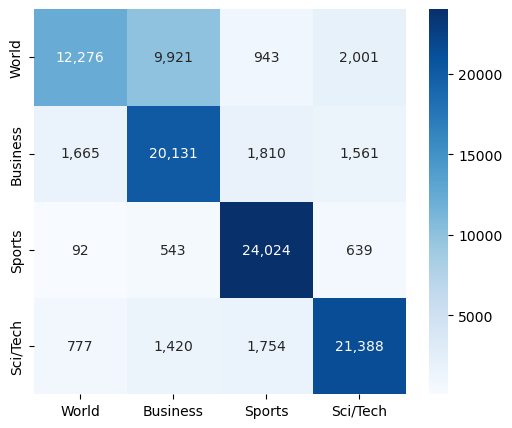

In [30]:
# Plot the confusion matrix on the train set

confmat = sklearn.metrics.confusion_matrix([idx2cat[idx] for idx in y_train], 
                                      [idx2cat[idx] for idx in best_nmf_clf.predict(X_train_tfidf)])
df_confmat = pd.DataFrame(confmat, index=categories, columns=categories)
plt.figure(figsize=(6, 5))
sns.heatmap(df_confmat, annot=True, fmt=',.0f', cmap="Blues");

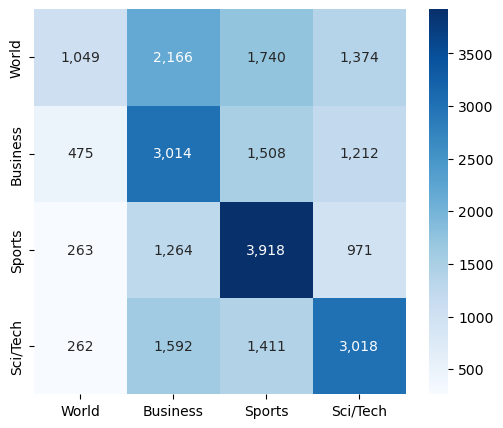

In [31]:
# Plot the confusion matrix on the test set

confmat_test = sklearn.metrics.confusion_matrix([idx2cat[idx] for idx in y_test], 
                                      [idx2cat[idx] for idx in best_nmf_clf.predict(X_test_tfidf, test=True)])
df_confmat_test = pd.DataFrame(confmat_test, index=categories, columns=categories)
plt.figure(figsize=(6, 5))
sns.heatmap(df_confmat_test, annot=True, fmt=',.0f', cmap="Blues");

*It's pretty obvious that the prediction on the test dataset is not really good. Among the mistakenly predicted categories, business tend to be confused with sports dominantly.*

#### Logistic Regression on TF-IDF

In [32]:
# Baseline logistic regression
# lg_clf = sklearn.linear_model.LogisticRegression().fit(X_train_tfidf, y_train)
# y_train_pred = lg_clf.predict(X_train_tfidf)
# acc_lg = np.mean(y_train_pred==y_train)
# acc_lg

*Search for optimal parameters for Logistric Regression*

In [33]:
lg_param_grid = {"penalty": ["l1", "l2"], 
                  "C": [0.001, 0.01, 0.1, 1, 3, 10], 
                  "solver": ["liblinear","saga", "lbfgs"]}

lg_grid = sklearn.model_selection.GridSearchCV(sklearn.linear_model.LogisticRegression(),
                                                param_grid=lg_param_grid, 
                                                scoring="accuracy", n_jobs=-1, cv=4)
lg_grid.fit(X_train_tfidf, y_train)
print(lg_grid.best_estimator_, lg_grid.best_score_)
best_lg_clf = lg_grid.best_estimator_.fit(X_train_tfidf, y_train)

/opt/conda/envs/cell2loc_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/cell2loc_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

LogisticRegression(C=1, penalty='l1', solver='liblinear') 0.8841646400555134


*Apply the best model on the test data and compute the accuracy*

In [34]:
y_test_lg = best_lg_clf.predict(X_test_tfidf)
test_acc_lg = np.mean(y_test_lg==y_test)
test_acc_lg

0.4431588540634782

#### SVM on TF-IDF

In [35]:
# svm_clf = sklearn.svm.SVC().fit(X_train_tfidf, y_train)
# y_train_pred = svm_clf.predict(X_train_tfidf)
# y_test_pred = svm_clf.predict(X_test_tfidf)
# acc_svm_train = np.mean(y_train_pred==y_train)
# acc_svm_test = np.mean(y_test_pred==y_test)

In [36]:
# acc_svm_train, acc_svm_test

*Search for optimal parameters for SVM*

In [ ]:
svm_param_grid = {"kernel": ["linear", "rbf", "sigmoid"], 
                  "C": [0.01, 0.1, 1, 3, 10], 
#                   "C": [0.01, 0.1], 
                  "gamma": ["scale","auto"]}
svm_grid = sklearn.model_selection.GridSearchCV(estimator=sklearn.svm.SVC(), 
                                                param_grid=svm_param_grid, 
                                                scoring="accuracy", n_jobs=-1, cv=4)
svm_grid.fit(X_train_tfidf, y_train)
print(svm_grid.best_estimator_, svm_grid.best_score_)
best_svm_clf = svm_grid.best_estimator_.fit(X_train_tfidf, y_train)

*Apply the best model on the test data and compute the accuracy*

In [ ]:
y_test_svm = best_svm_clf.predict(X_test_tfidf)
test_acc_svm = np.mean(y_test_svm==y_test)
test_acc_svm

#### Random Forest on TF-IDF

In [ ]:
# rf_clf = sklearn.ensemble.RandomForestClassifier().fit(X_train_tfidf, y_train)
# y_train_pred = rf_clf.predict(X_train_tfidf)
# acc_rf = np.mean(y_train_pred==y_train)
# acc_rf

*Search for optimal parameters for RF*

In [ ]:
rf_param_grid = {"n_estimators": [100, 200, 300, 500], "max_depth": [2, 3, 5, 10, 20]}
rf_grid = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.RandomForestClassifier(), 
                                               param_grid=rf_param_grid, scoring="accuracy", n_jobs=-1, cv=4)
rf_grid.fit(X_train_tfidf, y_train)
print(rf_grid.best_estimator_, rf_grid.best_score_)
best_rf_clf = rf_grid.best_estimator_.fit(X_train_tfidf, y_train)

*Apply the best model on the test data and compute the accuracy*

In [ ]:
y_test_rf = best_rf_clf.predict(X_test_tfidf)
test_acc_rf = np.mean(y_test_rf==y_test)
test_acc_rf

## Results and Analysis

I decided to use this AG News dataset due to the extensive experience I accumulated with the Week 4 assignment on the BBC news classification. However, the BBC news datasets is a relatively small dataset than many real-world datasets. Therefore, it makes it a worthy task to continue with a more realistic dataset for the modeling process. 

The AG News dataset is well structured and does not need much cleaning/imputation, except for some news description duplication removal.

Upon testing with three different featurizing methods, TF-IDF, word2vec and LDA. It seems like the TF-IDF and word2vec based features separates the clusters better than the LDA. As I have more experience with TF-IDF, I decided to proceed with TF-IDF.

Upon modeling the TF-IDF based features with four different ML methods, NMF, Logistic Regression, SVM and Random Forest. I computed the prediction accuracy scores for both training and test set and tabulated them as follows:


| Method   | NMF      | LR       | SVM      | RF       |
|----------|----------|----------|----------|----------|
| Train accuracy| 0.77     | 0.89     | NA       | 0.79     |
| Test accuracy | 0.44     | 0.44     | NA       | 0.42     |

The accuracy score from the training set were all obtained from the best model genrated by the corresponding GridSearch algorith. Due to computation resource limitation, I could not do more extensive searches on them. The best training accuracy is 0.89 from LR. And the best test accuracy is 0.44 from NMF or LR. The test accuracy scores are apparently all very poor in this case.


## Discussion

In this final project practice, I have combined what I learned from the course (general EDA, unsupervised learning, hyperparameter optimization) with additional essential techniques I learned from external to the course, such as text vectorization/featurization, and data transformation to apply them to the real world AG New category prediction dataset.


The code is fully automated except for the accuracy score tabulation. I have achieved generally good performance with the training dataset with all the ML methods I tested as show above in the results section. However, none of them reaches more than 0.5 accuracy score with the test dataset. One reason I can think of is, the data is inbalanced between the training and test set in terms of the underlying text structure, so that the rules we learned from the training set can not be generalized to the test set.

Another important note I want to make is that the SVM modeling on this dataset takes very long time. The GridSearch could not finish overnight. In the latest iteration to clean up and finalize the notebook. I could not finish them just in time before the submission, so, I don't have the accuracy scores for SVM models in this case. But I logged the scores for the RF model from previous runs.
